In [1]:
import os
import PIL
import shutil
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, save_model

2025-07-17 15:34:42.233070: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-17 15:34:42.262902: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752746682.303866  105954 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752746682.314124  105954 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752746682.345018  105954 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [4]:
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, untar=True)

In [5]:
type(data_dir)

str

In [ ]:
data_dir = pathlib.Path(data_dir)

In [7]:
image_count = len(list(data_dir.glob("*/*.jpg")))

In [8]:
image_count

0

In [9]:
data_dir = data_dir / "flower_photos"
image_count = len(list(data_dir.glob("*/*.jpg")))
print(f"New image count: {image_count}")

New image count: 3670


In [10]:
image_count

3670

In [11]:
batch_size = 32
img_height = 180
img_width = 180

In [14]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [16]:
class_names = train_ds.class_names
print("Class Names:", class_names)

Class Names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [17]:
train_ds = train_ds.cache().shuffle(1000)

val_ds = val_ds.cache()

In [18]:
num_classes = len(class_names)
num_classes

5

In [21]:
# Modeling

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),

    layers.Dense(num_classes)
])

/home/petpooja-1154/.local/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [23]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

None


In [24]:
epochs = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - accuracy: 0.3320 - loss: 1.5087 - val_accuracy: 0.5695 - val_loss: 1.0929
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 190ms/step - accuracy: 0.6159 - loss: 0.9690 - val_accuracy: 0.5913 - val_loss: 1.0395
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 189ms/step - accuracy: 0.6764 - loss: 0.8266 - val_accuracy: 0.6117 - val_loss: 0.9881
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - accuracy: 0.7748 - loss: 0.6513 - val_accuracy: 0.6458 - val_loss: 0.9348
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - accuracy: 0.8684 - loss: 0.4246 - val_accuracy: 0.6444 - val_loss: 1.0782
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.9180 - loss: 0.2584 - val_accuracy: 0.6526 - val_loss: 1.2569
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.9490 - loss: 0.1582 - val_accuracy: 0.6253 - val_loss: 1.4820
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 170ms/step - accuracy: 0.9780 - loss: 0.0749 - val_accu

In [27]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

In [28]:
loss = history.history['loss']

val_loss = history.history['val_loss']

In [29]:
epoch_range = range(epochs)
epoch_range

range(0, 50)

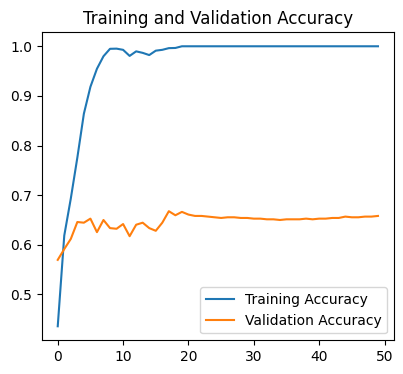

In [41]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epoch_range, acc, label="Training Accuracy")
plt.plot(epoch_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.show()

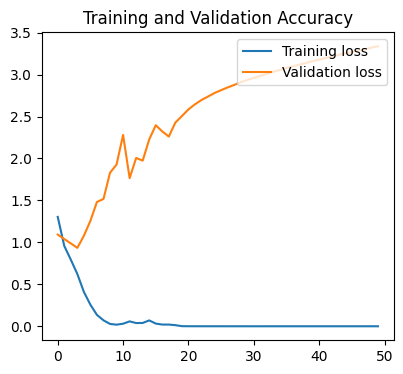

In [43]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epoch_range, loss, label="Training loss")
plt.plot(epoch_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Accuracy")
plt.show()

In [44]:
save_model(model, "flower_model_trained.hdf5")

print("Model saved successfully.")

Model saved successfully.
